<a href="https://colab.research.google.com/github/VEHEMENT2003/Machinelearnig/blob/main/MobileNetV2forimageclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set seeds for reproducibility
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

# Importing dependencies
import os
import json
from zipfile import ZipFile
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam



In [2]:
# Data Curation

# Install Kaggle and upload the kaggle.json file
!pip install kaggle


# Load Kaggle credentials
kaggle_credentials = json.load(open("/content/kaggle (1).json"))

# Setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]

# Download the PlantVillage dataset
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

# Unzip the downloaded dataset
with ZipFile("plantvillage-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()
print(os.listdir("plantvillage dataset"))


Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.04G/2.04G [01:34<00:00, 24.2MB/s]
100% 2.04G/2.04G [01:34<00:00, 23.2MB/s]
['segmented', 'color', 'grayscale']


In [3]:

# Dataset Path
base_dir = 'plantvillage dataset/color'
img_size = 224
batch_size = 32

# Data Preprocessing
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of data for validation
)

# Train Generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

# Validation Generator
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)


Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


In [4]:

# Model Definition with MobileNetV2 as base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freezing base model layers
for layer in base_model.layers:
    layer.trainable = False

# Adding custom layers on top of MobileNetV2
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
predictions = layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Model summary
model.summary()



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,595,686 (9.90 MB)

 Trainable params: 337,702 (1.29 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 99s 68ms/step - accuracy: 0.9685 - loss: 0.0909 - val_accuracy: 0.9486 - val_loss: 0.1558
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 2.3842e-06
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 91s 67ms/step - accuracy: 0.9780 - loss: 0.0633 - val_accuracy: 0.9537 - val_loss: 0.1558
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 5/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 88s 65ms/step - accuracy: 0.9817 - loss: 0.0526 - val_accuracy: 0.9503 - val_loss: 0.1710
Evaluating model...
339/339 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.9489 - loss: 0.1715
Validation Accuracy: 95.03%


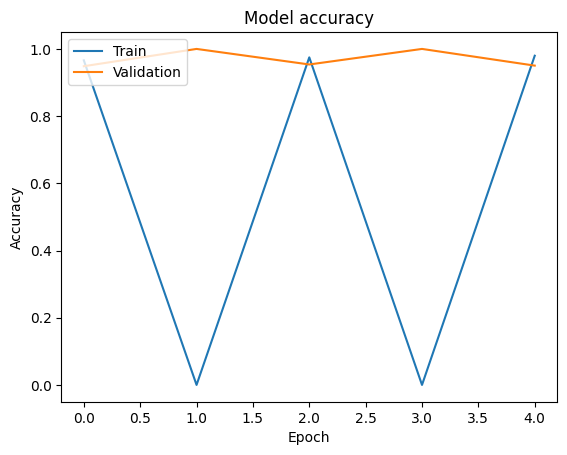

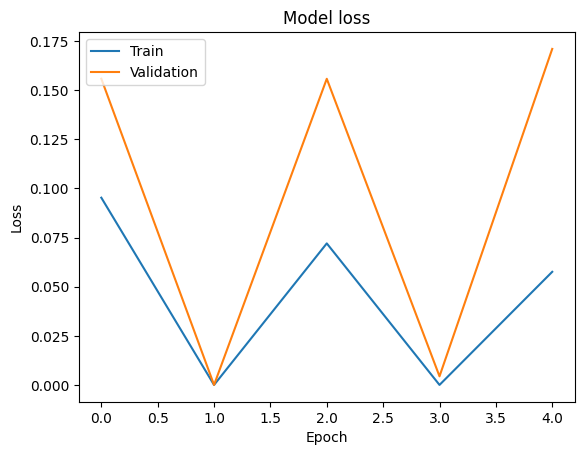

In [6]:
# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Model Evaluation
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


340/340 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step


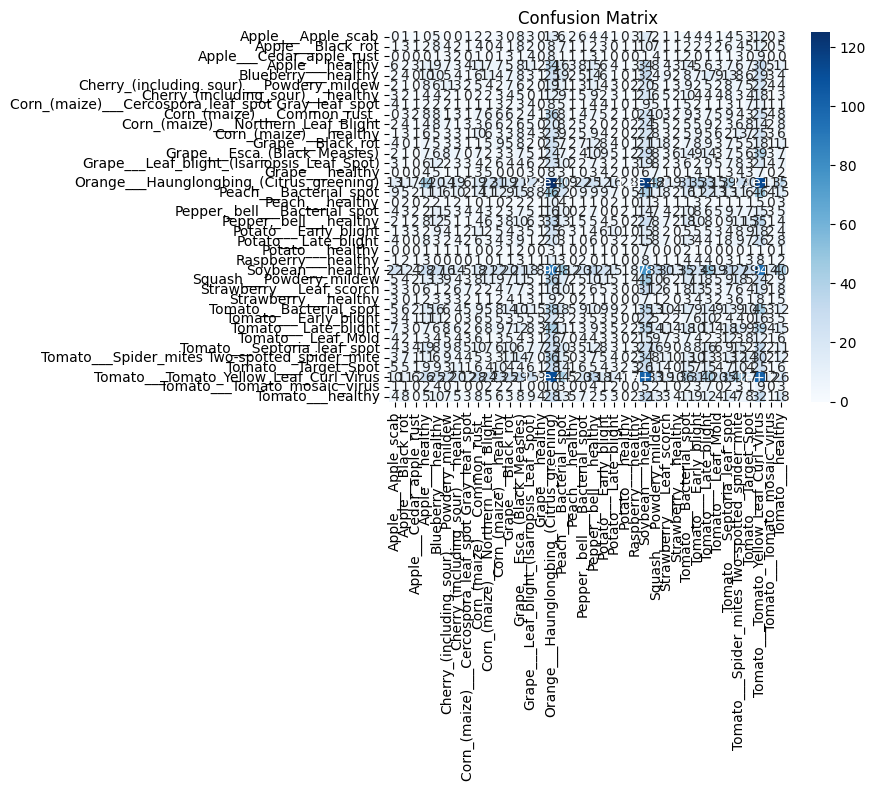

Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00       126
                                 Apple___Black_rot       0.02      0.02      0.02       124
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        55
                                   Apple___healthy       0.03      0.03      0.03       329
                               Blueberry___healthy       0.03      0.03      0.03       300
          Cherry_(including_sour)___Powdery_mildew       0.06      0.05      0.05       210
                 Cherry_(including_sour)___healthy       0.01      0.01      0.01       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.01      0.01      0.01       102
                       Corn_(maize)___Common_rust_       0.03      0.03      0.03       238
               Corn_(maize)___Northern_Leaf_Blight     

In [8]:

#Bias and Fairness Evaluation
# Install seaborn if not already installed
!pip install seaborn
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.show()

# Classification report for detailed analysis
print("Classification Report:\n")
print(classification_report(validation_generator.classes, y_pred, target_names=validation_generator.class_indices.keys()))


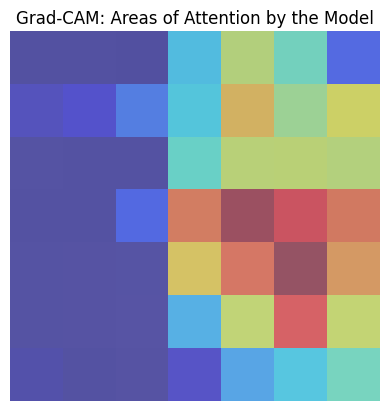

In [9]:
#Model Transparency and Explainability (Using Grad-CAM)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Function to generate Grad-CAM heatmap
def get_grad_cam(model, img_array, last_conv_layer_name="Conv_1"):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Load sample image
img_path = "/content/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG"  # Replace with an actual image path
img = load_img(img_path, target_size=(224, 224))
img_array = np.expand_dims(img_to_array(img) / 255., axis=0)

# Generate Grad-CAM heatmap
heatmap = get_grad_cam(model, img_array)

# Display heatmap
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
plt.title("Grad-CAM: Areas of Attention by the Model")
plt.axis("off")
plt.show()


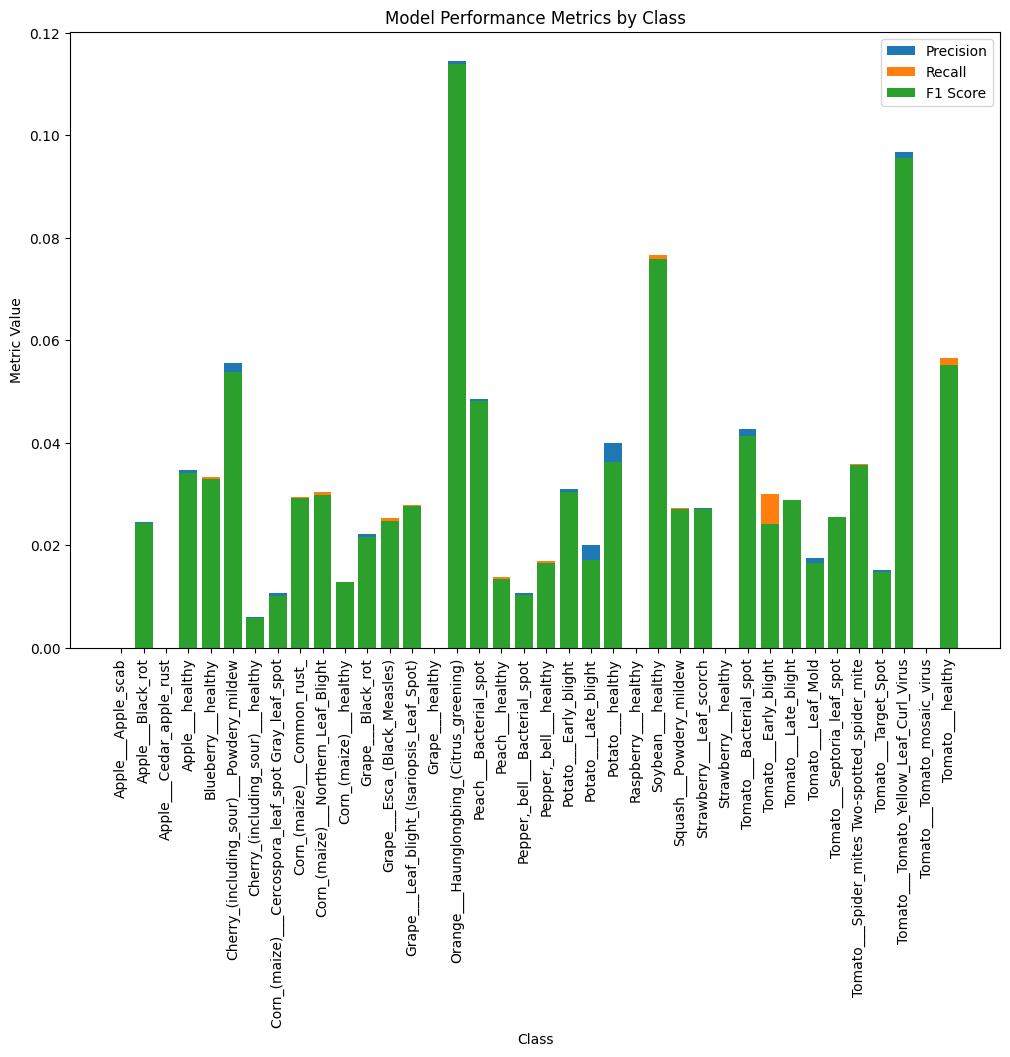

In [10]:
# Performance Metrics Across Subgroups
from sklearn.metrics import precision_score, recall_score, f1_score

true_labels = validation_generator.classes
precision = precision_score(true_labels, y_pred, average=None)
recall = recall_score(true_labels, y_pred, average=None)
f1 = f1_score(true_labels, y_pred, average=None)

# Plot metrics per class
labels = list(validation_generator.class_indices.keys())
plt.figure(figsize=(12, 8))
plt.bar(labels, precision, label='Precision')
plt.bar(labels, recall, label='Recall')
plt.bar(labels, f1, label='F1 Score')
plt.xticks(rotation=90)
plt.title("Model Performance Metrics by Class")
plt.xlabel("Class")
plt.ylabel("Metric Value")
plt.legend()
plt.show()
